## Using the em/feat/muinversion branch of SimPEG (http://github.com/simpeg/simpeg)

In [1]:
from CasingSimulations import * 
%matplotlib inline

In [2]:
directory = 'UniformBackground1kmCasing'
cpfile = "CasingProperties.json"
resultsfile = "MagneticPermeabilityImpacts.hdf5"
rerun = False

# Model Parameters

In [3]:
# Save or load Results
cp_file = '{directory}/{cpfile}'.format(directory=directory, cpfile=cpfile)

if rerun is True:   
    cp = CasingProperties()
else:   
    with open(cp_file, 'r') as outfile:   
        cp = CasingProperties.deserialize(json.load(outfile))

In [4]:
mesh = CasingMesh(cp).mesh

In [5]:
print(
    'Cyl Mesh Extent xmax: {},: zmin: {}, zmax: {}'.format(
        mesh.vectorCCx.max(),
        mesh.vectorCCz.min(),
        mesh.vectorCCz.max()
    )
)

print(mesh.nC)
print([500./np.sqrt(cp.sigmaback*f) for f in cp.freqs])
print([500./np.sqrt(cp.sigmacasing*f) for f in cp.freqs])

Cyl Mesh Extent xmax: 702446.341501,: zmin: -615296.090052, zmax: 614296.590053
2450492
[500000.0, 158113.88300841895, 50000.0, 15811.388300841898, 7071.0678118654751, 5000.0]
[21.320071635561042, 6.7419986246324211, 2.1320071635561044, 0.67419986246324204, 0.30151134457776363, 0.21320071635561044]


# plot model

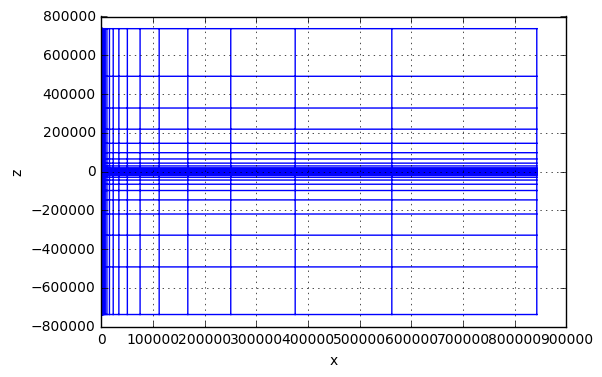

In [6]:
fig, ax = plt.subplots(1,1)
mesh.plotGrid(ax=ax)

# fig.savefig('{}/{}'.format(directory, 'CylMesh.png'))

In [7]:
indActive=mesh.gridCC[:,2] <= 0.
casingMap = Maps.ParametrizedCasingAndLayer(mesh, indActive=indActive, slope=1e8)
actMap_sigma = Maps.InjectActiveCells(mesh, indActive=indActive, valInactive=np.log(cp.sigmaair))
actMap_mu = Maps.InjectActiveCells(mesh, indActive=indActive, valInactive=mu_0)
expMap = Maps.ExpMap(mesh)

sigmaMap = expMap * actMap_sigma * casingMap
muMap = actMap_mu * casingMap

In [8]:
muModelInd = 1

sigma_m = np.r_[
    np.log(cp.sigmaback), np.log(cp.sigmalayer), np.log(cp.sigmacasing), np.log(cp.sigmainside),
    cp.layer_z.mean(), cp.layer_z[1] - cp.layer_z[0], cp.casing_r, cp.casing_t, 
    cp.casing_z[0], cp.casing_z[1]
]

mu_m = np.r_[
    mu_0, mu_0, cp.muModels[muModelInd]*mu_0, mu_0,
    cp.layer_z.mean(), cp.layer_z[1] - cp.layer_z[0], cp.casing_r, cp.casing_t, 
    cp.casing_z[0], cp.casing_z[1]
]

In [9]:
%%time
sigma = sigmaMap * sigma_m
mu = muMap * mu_m

CPU times: user 24.7 s, sys: 976 ms, total: 25.6 s
Wall time: 26.8 s


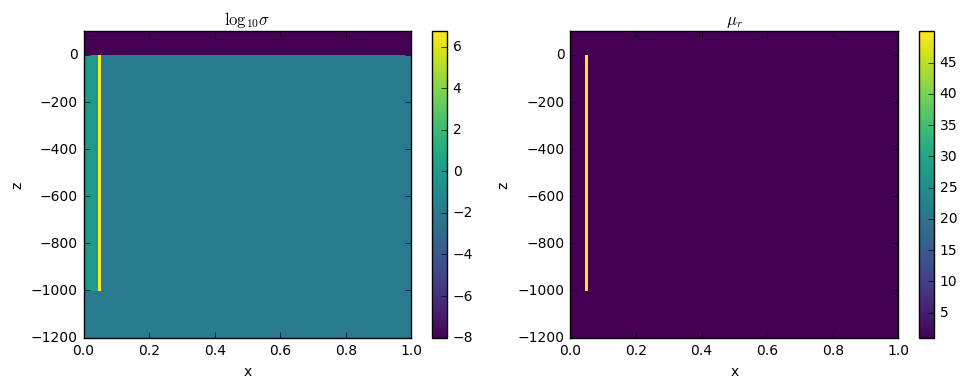

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax = plotModels(mesh, sigma, mu, xlim=[0.,1.], zlim=[-1200., 100.], ax=ax)
# fig.savefig('{}/{}'.format(directory, 'PhysPropModels'))

# Set up the Source

In [11]:
# down-holeSource
dhSrc = DownHoleCasingSrc(mesh, cp.src_a, cp.src_b, cp.casing_a, cp.freqs)

(-951.0, -949.0)

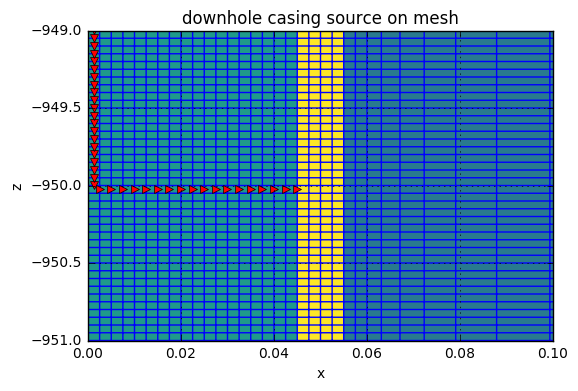

In [12]:
# Plot the source to make sure the path is infact
# connected

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
mesh.plotImage(np.log10(sigma), ax=ax)
mesh.plotGrid(ax=ax)
dhSrc.plotSrc(ax=ax)

ax.set_title('downhole casing source on mesh')

ax.set_xlim([0, 0.1])
ax.set_ylim([-951., -949.])

# fig.savefig('{}/{}'.format(directory, 'SourceOnMesh.png'))

# Problem and Survey

In [13]:
prob = FDEM.Problem3D_h(mesh, sigma=sigma, muMap=muMap)
survey = FDEM.Survey(dhSrc.dg_p)

prob.pair(survey)

In [14]:
def MuCasingModel(mucasing):
    return np.r_[
        mu_0, mu_0, mucasing*mu_0, mu_0,
        cp.layer_z.mean(), cp.layer_z[1] - cp.layer_z[0], cp.casing_r, cp.casing_t, 
        cp.casing_z[0], cp.casing_z[1]
    ]

In [15]:
cp.muModels = [1., 50., 100., 200.]
fields = {}

In [16]:
if rerun is True:
    # create a file to store results
    results = h5py.File("{}/{}".format(directory, resultsfile), "w")
else:
    results = h5py.File("{}/{}".format(directory, resultsfile), "r")

In [17]:
results.keys()

[u'fields_1', u'fields_100', u'fields_200', u'fields_50']

In [18]:
%%time
for muMod in cp.muModels:
    tag = int(muMod)
    curMu = MuCasingModel(muMod)

    if rerun is True:
        print('solving mu = {}mu_0'.format(tag))
        fields[tag] = prob.fields(curMu)
        dbentry = "fields_{tag}".format(tag=tag)
        results.create_dataset(dbentry, data=fields[tag][:,'hSolution'])
        print('... saved fields_{tag}'.format(tag=tag))
        
        # Save parameters used to produce these fields
        with open(cp_file, 'w') as outfile:
            json.dump(cp.serialize(), outfile)

    else:
        print('loading mu = {}mu_0'.format(tag))
        prob.model = curMu
        f = prob.fieldsPair(mesh, survey)
        f[:, 'hSolution'] = results['fields_{}'.format(tag)].value
        fields[tag] = f
        print('... loaded mu = {}mu_0'.format(tag))

loading mu = 1mu_0
... loaded mu = 1mu_0
loading mu = 50mu_0
... loaded mu = 50mu_0
loading mu = 100mu_0
... loaded mu = 100mu_0
loading mu = 200mu_0
... loaded mu = 200mu_0
CPU times: user 1min 36s, sys: 5.55 s, total: 1min 42s
Wall time: 1min 44s


0.0001 Hz, 1.0 mu_0


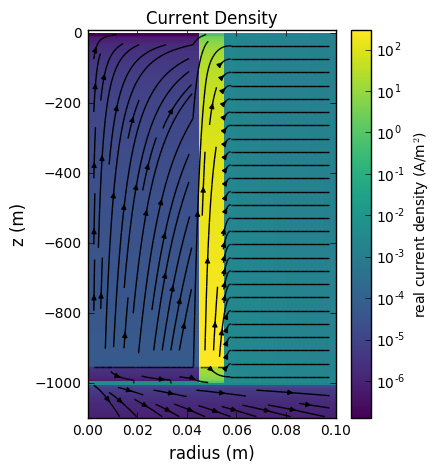

In [19]:
def vecplot_j(muind, freqind, reim='real'):
    src = survey.srcList[freqind]
    mur = cp.muModels[muind]
    
    print('{} Hz, {} mu_0'.format(cp.freqs[freqind], mur))
    ax = plotCurrentDensity(
        mesh, fields[mur][src, 'j'], csx=0.005, csz=5., 
        xmax=0.1, zmin=10., zmax=-1100., real_or_imag=reim
    )
    return ax

w = widgets.interactive(
        vecplot_j, muind=widgets.IntSlider(min=0, max=len(cp.muModels)-1),
        freqind=widgets.IntSlider(min=0, max=len(cp.freqs)-1),
        reim=widgets.ToggleButtons(options=['real', 'imag'])
)
w
#ax.axis('equal', adjustable='box')

In [20]:
# find indices where the cell centers are in the casing
casing_ind = sigma_m.copy()
casing_ind[[0, 1, 3]] = 0. # zero outside casing
casing_ind[2] = 1. # 1 inside casing 

actMap_Zeros = Maps.InjectActiveCells(mesh, indActive, 0.)

indCasing = actMap_Zeros * casingMap * casing_ind

(-1100.0, 10.0)

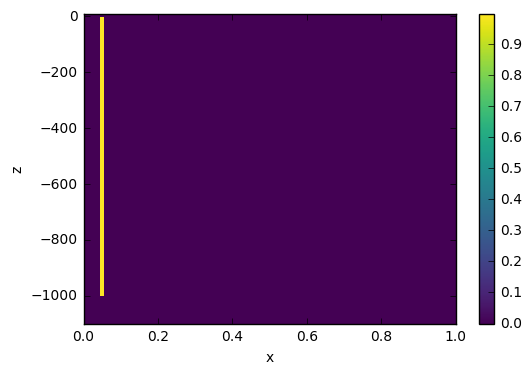

In [21]:
# plot to sanity-check
fig, ax = plt.subplots(1,1)
f = mesh.plotImage(indCasing, ax=ax)
plt.colorbar(f[0])
ax.set_xlim([0., 1.])
ax.set_ylim([-1100., 10.])

In [22]:
mur = 100
j = fields[mur][:,'j']
jA = Utils.sdiag(mesh.area) * j

print jA.shape

(4901106, 6)


In [23]:
casing_faces = mesh.aveF2CC.T * indCasing
casing_faces[casing_faces < 0.25] = 0

print casing_faces.nonzero()

(array([   4654,    4655,    4656, ..., 4895025, 4895026, 4895027]),)


(-950.0, -951.0)

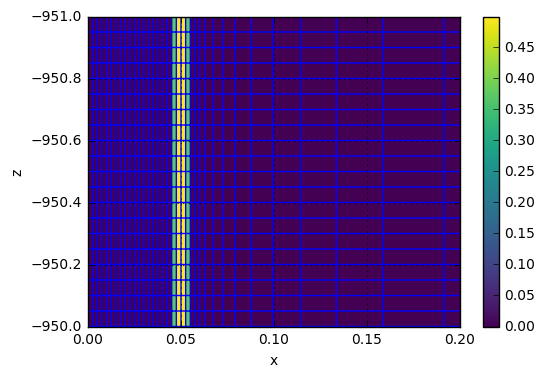

In [24]:
fig, ax = plt.subplots(1)
f = mesh.plotImage(mesh.aveF2CC * casing_faces, ax=ax)
plt.colorbar(f[0])
mesh.plotGrid(ax=ax)
ax.set_xlim([0., 0.2])
ax.set_ylim([-950., -951.])


In [25]:
%%time 

IxCasing, IzCasing = CasingCurrents(cp, fields, mesh, sigma_m, indActive, casingMap)

CPU times: user 32.8 s, sys: 7.14 s, total: 39.9 s
Wall time: 43.5 s


mu = 1.0 mu_0


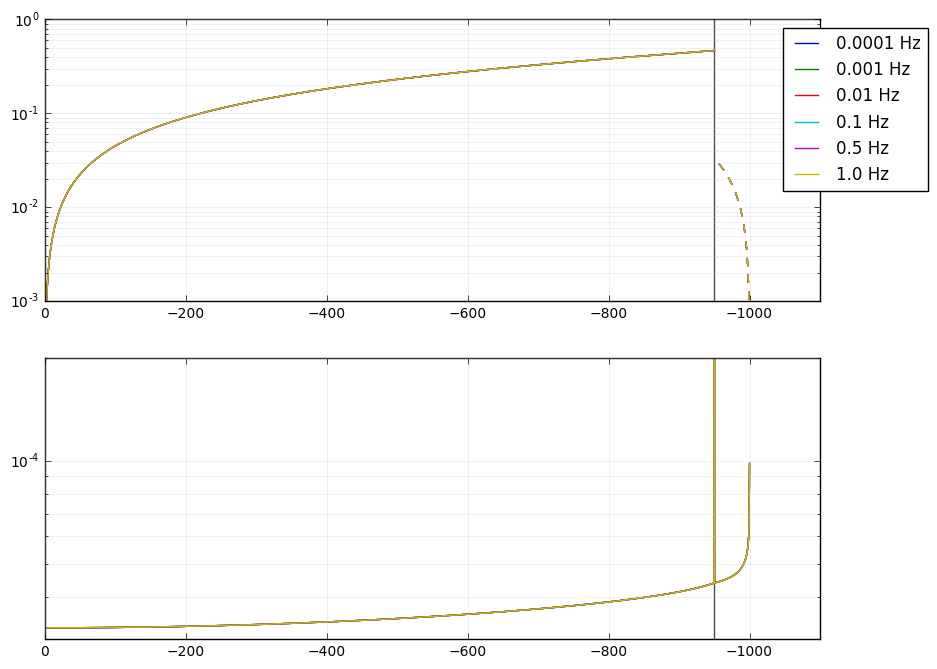

In [26]:
def plotMe_freq(muopt, reim, subtract=None):
#     fig, ax = plt.subplots(2,1, figsize=(10,8))
    mur = cp.muModels[muopt]
    plot_currents_over_freq(
        IxCasing, IzCasing, cp, mesh, mur, subtract=subtract, real_or_imag=reim
    ) #, ax=ax)  

w = widgets.interact(
    plotMe_freq, 
    muopt=widgets.IntSlider(min=0., max=len(cp.muModels)-1), 
    reim=widgets.ToggleButtons(options=['real', 'imag']),
    subtract=widgets.ToggleButtons(options=[None, 1])
)


0.0001 Hz


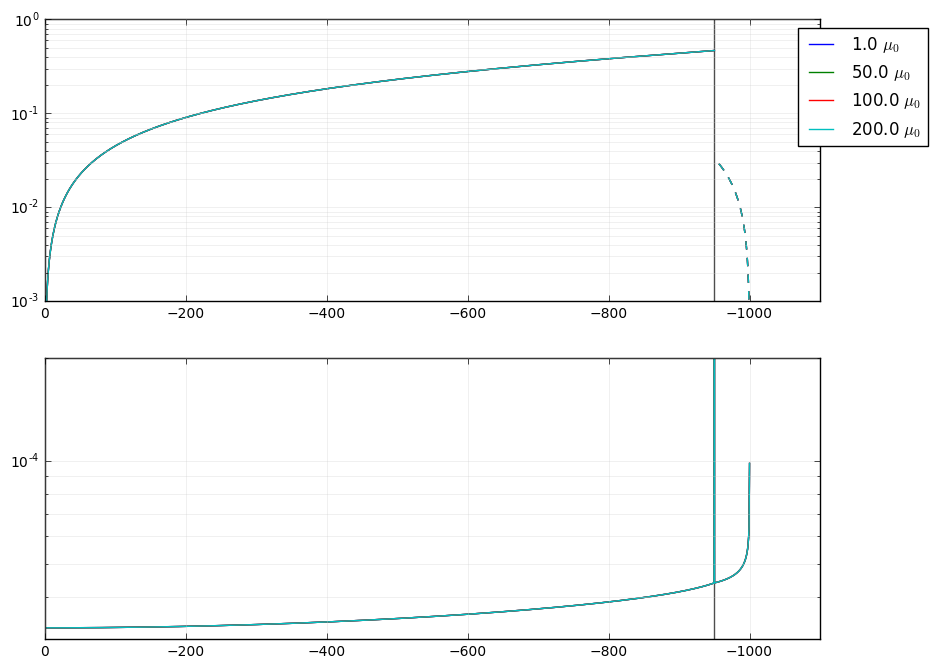

<function __main__.plotMe_mu>

In [27]:
def plotMe_mu(freqopt, reim, subtract=None):
#     fig, ax = plt.subplots(2,1, figsize=(10,8))
    freq = cp.freqs[freqopt]
    plot_currents_over_mu(IxCasing, IzCasing, cp, mesh, freqopt, subtract=subtract, real_or_imag=reim)  

w = widgets.interact(
    plotMe_mu, 
    freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1), 
    reim=widgets.ToggleButtons(options=['real', 'imag']),
    subtract=widgets.ToggleButtons(options=[None, 1])
)

w

0.0001 Hz


<function __main__.plotMe_j_mu_z>

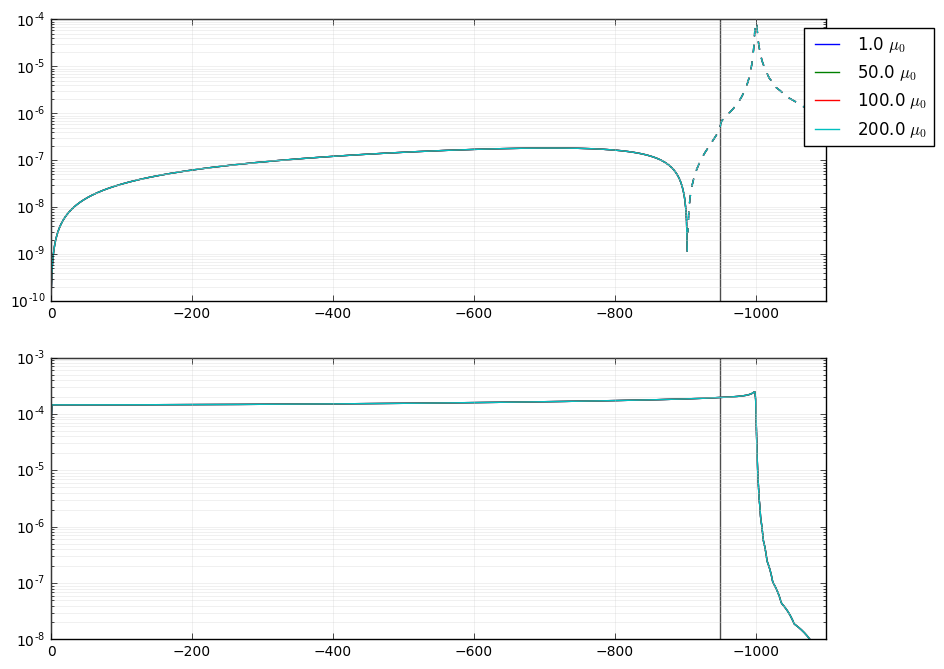

In [29]:
def plotMe_j_mu_z(freqopt, reim, r, subtract=None):
#     fig, ax = plt.subplots(2,1, figsize=(10,8))
    freq = cp.freqs[freqopt]
    plot_j_over_mu_z(cp, fields, mesh, survey, freqopt, subtract=subtract, r=r, real_or_imag=reim)  

widgets.interact(
    plotMe_j_mu_z, 
    freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1), 
    r=widgets.FloatText(value=1.), 
    reim=widgets.ToggleButtons(options=['real', 'imag']),
    subtract=widgets.ToggleButtons(options=[None, 1])
)

0.0001 Hz


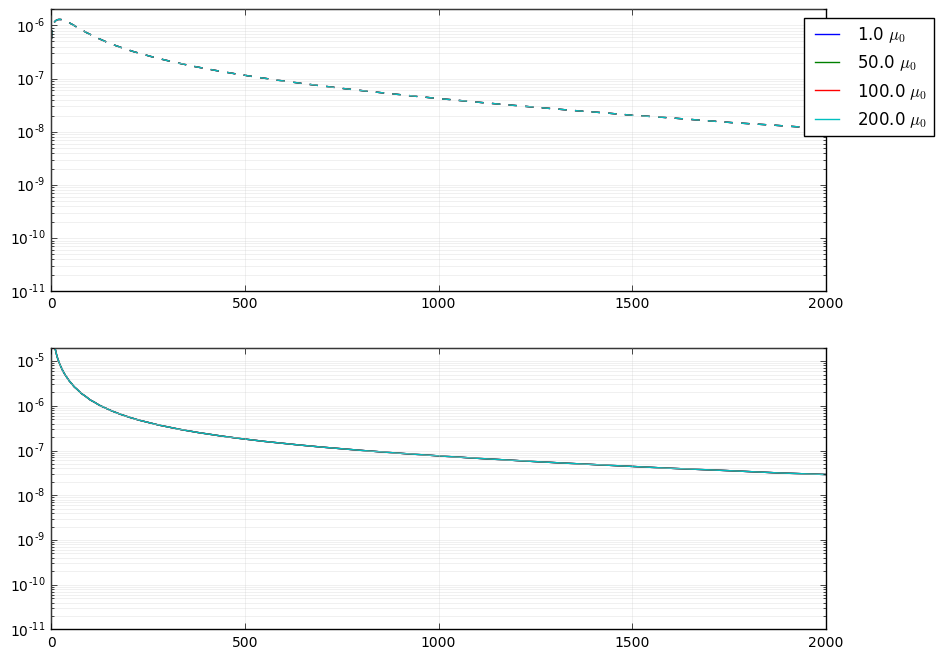

In [30]:
def plotMe_j_mu_x(freqopt, reim, z, subtract=None):
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    freq = cp.freqs[freqopt]
    plot_j_over_mu_x(cp, fields, mesh, survey, freqopt, subtract=subtract, z=z, real_or_imag=reim, ax=ax)
    plt.show()

j_over_x = widgets.interactive(
    plotMe_j_mu_x, 
    freqopt=widgets.IntSlider(min=0., max=len(cp.freqs)-1, continuous_update=False), 
    z=widgets.FloatText(value=-950., continuous_update=False), 
    subtract=widgets.ToggleButtons(options=[None, 1], continuous_update=False), 
    reim=widgets.ToggleButtons(options=['real', 'imag'], continuous_update=False)
)
j_over_x